<h3>Лабораторная работа №6</h3>
<p style="font-size: 16px">Построение общей модели на основе случайных полей
и статической модели блокировки</p>
<hr>
<p style="font-size: 14px">Цель:</p>
<ol>
    <li>Ознакомление с общей моделью на основе случайных полей и статической модели
блокировки.</li>
</ol>
<hr>
<p><b><u>Задание</u></b></p>
<p style="width: 60%">В круге радиуса R, центром которого является целевой приемник,
распределены согласно Пуассоновскому равномерному точечному процессу с
интенсивностью B интерферирующие устройства. На целевом приемнике
расположена всенаправленная антенна, а интерферирующие устройства
оборудованы направленными антеннами с углом диаграммы направленности γ.
Предполагается, что все антенны сориентированы случайным образом и постоянно
излучают сигнал с мощностью P. При этом применяется модель распространения
сигнала Cone (аналог модели Free Space Path Loss с поправкой на коэффициент
диаграммы направленности). В этом же круге согласно Пуассоновскому
равномерному точечному процессу с интенсивностью A распределены
блокирующие объекты радиуса D. Для упрощения интерферирующие устройства не
считать блокирующими объектами.</p>
<p style="width: 60%">В случае если сигнал от интерферирующего передатчика до целевого
приемника проходит через блокирующий объект, то он не создает помех на целевом
приемнике. Аналогично, если целевой приемник не попадает в сектор диаграммы
направленности интерферирующего передатчика, то соответствующий
интерферирующий сигнал тоже не создает помех.</p>
<p style="width: 60%">На основе полученной модели построить графики среднего значения
интерференции как функции от направленности антенн γ, интенсивности
Пуассоновского поля источников интерферирующих устройств B, интенсивности
Пуассоновского поля блокирующих объектов A. При построении графиков
использовать как минимум 1000 реализаций.</p>
<hr>

In [80]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import math as m
import scipy.stats as st

In [70]:
R = 10 # Радиус исследуемой окружности
D = 0.4 # Радиусы блокирующих объектов
P_MAX = 1 # Величина интерференции при совпадении вектора направленности с линией прямой видимости
SAFE_ZONE = R / 10 # Исключаем генерацию вблизи станции

# Переменные для изменения для построения графиков
A = 0.2
B = 0.4
gamma = 0.5

# Генерировать точки будем по методу квдарата, т.к. этот метод показал более равномерное распределение, нежели чем по радиусу и углу
# k - коэффициент для подстановки, в функцию подаются коэффициенты А или В
def giveMeObjects(k):
    totalPoints = m.floor(k * m.pi * R ** 2.0)
    xObjects = []
    yObjects = []

    # Генерируем точку по квадрату, и, если расстояние до центра окружности (т.е. до (0, 0)) меньше радиуса, добавляем в итоговый список
    while (len(xObjects) < totalPoints):
        x = np.random.uniform(low = -R, high = R)
        y = np.random.uniform(low = -R, high = R)
        if ((m.sqrt(x ** 2.0 + y ** 2.0) < R) and (abs(x) > SAFE_ZONE) and (abs(y) > SAFE_ZONE)):
            xObjects.append(x)
            yObjects.append(y)

    return xObjects, yObjects

# Вспомогательная функция для нахождения расстояния между точками
# Опциональными будут координаты второй точки, чтобы сократить количество кода при подсчёте расстояния до центра окружности
def findDistance(xFirst, yFirst, xSecond = 0.0, ySecond = 0.0):
    return m.sqrt((xFirst - xSecond) ** 2.0 + (yFirst - ySecond) ** 2.0 )

# Вспомогательная функция для определения, блокируется ли интерф. источник
def isLocked(xL, yL, x, y):
    AB = findDistance(x, y) # Найдем расстояние от центра до интерф. источника

    # В этот раз я решил поступить чуточку умнее:
    # Теперь для определения, блокируется ли источник, нахожу высоту CH треугольника ABC, где А - центр окружности, 
    # В - интерф. источник, С - центр блокирующего объекта
    # Вычисления немного сокращаются, т.к. мы знаем, что точка А имеет координаты (0,0)
    # Если высота CH меньше радиуса блокирующего объекта, то источник заблокирован, возвращаем true
    for i in range(len(xL)):
        doubleS = abs(x * yL[i] - xL[i] * y)       
        if ((doubleS / AB) < D):
            return True
    
    return False

# Функция, которая нам будем сообщать итоговое значение уровня интерференции
# в зависимости от угла направленности и списков: положений блокирующих, интерферирующих объектов, векторов направленности ( в виде углов )
def totalPValue(xL, yL, xI, yI, anglesI, gam):
    P = 0

    GAdd = 2 / (1 - m.cos(gam / 2)) / 4 / m.pi

    for i in range(len(xI)):
        # Для начала найдём, не блокируется ли интерферирующий источник
        # Если блокируется, переходим к следующему
        if (isLocked(xL, yL, xI[i], yI[i])):
            continue

        # Cнова решил поступить умнее для определения видимости.
        # Теперь вместо многоусловного нахождения попадания центра окружности в диаграмму направленности
        # Строю треугольник АВС, у которого А - центр окружности, С - интерф. источник, В - точка, такая, что:
        # ВС = АС, а вектор CB совпадает с вектором направленности для данного источника из списка anglesI
        side = findDistance(xI[i], yI[i])
        xV = m.cos(anglesI[i]) * side + xI[i]
        yV = m.sin(anglesI[i]) * side + yI[i]
        base = findDistance(xV, yV)

        # Теорема косинусов
        resultAngle = abs(m.acos((2 * side ** 2.0 - base ** 2.0) / (2 * side ** 2.0)))
        # Если полученный угол АСВ меньше угла гаммы, то прибавляем значение с поправкой на коэффициент в Р
        if (resultAngle < gam / 2):
            P += P_MAX * 2 * GAdd / side ** 2

    return P

После всех подготовительных работ можно начать генерации и построения. Нам нужно построить функцию от плотностей А и Б, а так же от угла gamma - угла направленности (в rad). Поступаем следующим образом: вызываем генерации точек 1000 раз (по условию), на каждую генерацию получаем значения фукнций, все значения функций усредняем по генерациям. Разбивать функцию <del>так же будем на 1000 точек</del> лучше на 100.

In [71]:
TOTAL_CHECKS = 1000 # Количество проверок
TOTAL_DISCR = 100 # На сколько точек дискретизируем функции

aFuncValues = [0.0] * TOTAL_DISCR
bFuncValues = [0.0] * TOTAL_DISCR
gammaFuncValues = [0.0] * TOTAL_DISCR

aLinspace = np.linspace(0.2, 1, TOTAL_DISCR)
bLinspace = np.linspace(0.2, 1, TOTAL_DISCR)
gamLinspace = np.linspace(0.2, 2 * m.pi, TOTAL_DISCR)

print('Началась генерация для плотности интерферирующих источников')
for i in range(TOTAL_CHECKS): # Для функции по плотностям А и В придётся делать 1000 генераций :(
    for j in range(TOTAL_DISCR):
        xI, yI = giveMeObjects(aLinspace[j])
        xL, yL = giveMeObjects(B)
        anglesI = np.random.uniform(low = 0, high = 2 * m.pi, size =  len(xI))

        aFuncValues[j] += totalPValue(xL, yL, xI, yI, anglesI, gamma)

print('Началась генерация для плотности блокирующих объектов')
for i in range(TOTAL_CHECKS):
    for j in range(TOTAL_DISCR):
        xL, yL = giveMeObjects(bLinspace[j])
        xI, yI = giveMeObjects(A)
        anglesI = np.random.uniform(low = 0, high = 2 * m.pi, size = len(xI))

        bFuncValues[j] += totalPValue(xL, yL, xI, yI, anglesI, gamma)

print('Началась генерация для гамма углов')
for i in range(TOTAL_CHECKS):
    xL, yL = giveMeObjects(B)
    xI, yI = giveMeObjects(A)
    anglesI = np.random.uniform(low = 0, high = 2 * m.pi, size = len(xI))
    for j in range(TOTAL_DISCR):
        gammaFuncValues[j] += totalPValue(xL, yL, xI, yI, anglesI, gamLinspace[j])

for i in range(TOTAL_DISCR):
    aFuncValues[i] /= TOTAL_CHECKS
    bFuncValues[i] /= TOTAL_CHECKS
    gammaFuncValues[i] /= TOTAL_CHECKS
print('Всё!')

Началась генерация для плотности интерферирующих источников
Началась генерация для плотности блокирующих объектов
Началась генерация для гамма углов
Всё!


На этом этапе можно наливать чай: видеть на ubuntu загрузку ЦП в 100% дело, всё же, непривычное...

После того, как мы всё просчитали, строим графики:

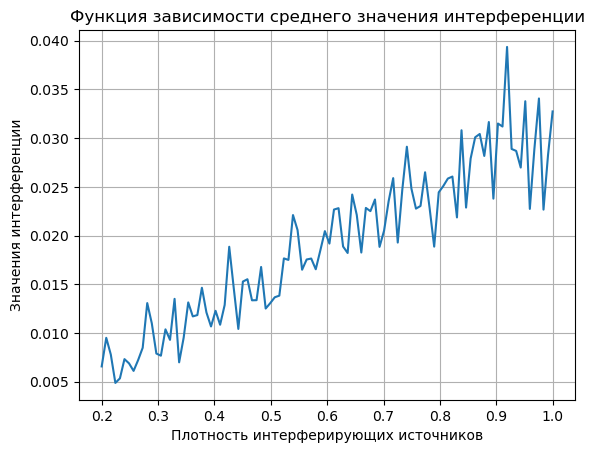

In [85]:
plt.plot(aLinspace, aFuncValues)

plt.title('Функция зависимости среднего значения интерференции')
plt.xlabel('Плотность интерферирующих источников')
plt.ylabel('Значения интерференции')

plt.grid()
plt.show()

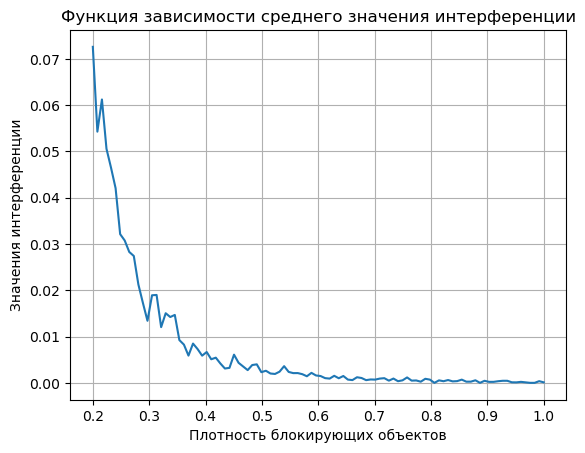

In [76]:
plt.plot(bLinspace, bFuncValues)

plt.title('Функция зависимости среднего значения интерференции')
plt.xlabel('Плотность блокирующих объектов')
plt.ylabel('Значения интерференции')

plt.grid()
plt.show()

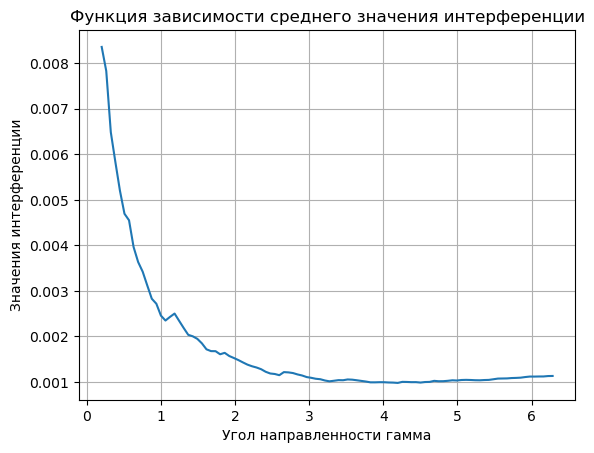

In [77]:
plt.plot(gamLinspace, gammaFuncValues)

plt.title('Функция зависимости среднего значения интерференции')
plt.xlabel('Угол направленности гамма')
plt.ylabel('Значения интерференции')

plt.grid()
plt.show()

<hr>
<h3>Выводы:</h3>
<ol>
    <li>Ознакомление с общей моделью на основе случайных полей и статической модели
блокировки.</li>
    <li>Сравнили математическую модель с псевдореальной ситуацией расположений объектов блокировок и источников интерференций на плоскости</li>
</ol>